<a href="https://colab.research.google.com/github/Sumit-Dwivedi/Intuitionistic-FCM-Smote/blob/Sumit/Fuzzy_C_Means_CENTER_SMOTE_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fuzzy-c-means

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: typer
    Found existing installation: typer 0.12.5
    Uninstalling typer-0.12.5:
      Successfully uninstalled typer-0.12.5
  Attempting uninstall: tabulate
    Found existing installation: tabulate 0.9.0
    Uninstalling tabulate-0.9.0:
      Successfully uninstalled tabulate-0.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.17.0 requires tabulate>=0.9, but you have tabulate 0.8.10 which is incompatible.


In [2]:
!pip install -q numpy scikit-learn imbalanced-learn

In [3]:
from sklearn.cluster import DBSCAN
import numpy as np

def extract_k_clusters_with_dbscan(X, k):
    """
    Extrait les k premiers clusters à partir des données en utilisant l'algorithme DBSCAN.

    Args:
    - X : Matrice des features
    - k : Nombre de clusters à extraire

    Returns:
    - clusters : Liste des k premiers clusters
    """
    # Appliquer DBSCAN pour obtenir les clusters
    dbscan = DBSCAN()
    dbscan.fit(X)

    # Obtenir les labels des clusters
    cluster_labels = dbscan.labels_

    # Identifier les k premiers clusters
    unique_labels = np.unique(cluster_labels)
    k_clusters = []
    for label in unique_labels:
        if label != -1 and len(k_clusters) < k:  # Ignorer le bruit (-1) et obtenir k clusters
            cluster = X[cluster_labels == label]
            k_clusters.append(cluster)

    return k_clusters


In [4]:
!pip install -U imbalanced-learn

In [5]:
import warnings
import math
import copy
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.utils import check_random_state
from sklearn.metrics.pairwise import euclidean_distances
from imblearn.over_sampling.base import BaseOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.exceptions import raise_isinstance_error
from imblearn.utils import check_neighbors_object
from imblearn.utils.deprecation import deprecate_parameter



In [6]:
from fcmeans import FCM
from sklearn.neighbors import NearestNeighbors
#from imblearn.over_sampling import BaseOverSampler, SMOTE
import copy

class FCMCENTERSMOTE(BaseOverSampler):

    def __init__(self, sampling_strategy='auto', random_state=None, kmeans_args=None, smote_args=None,
                 imbalance_ratio_threshold=1.0, density_power=None, use_minibatch_kmeans=True, n_jobs=1, **kwargs):
        super(FCMCENTERSMOTE, self).__init__(sampling_strategy=sampling_strategy, **kwargs)
        if kmeans_args is None:
            kmeans_args = {}
        if smote_args is None:
            smote_args = {}
        self.imbalance_ratio_threshold = imbalance_ratio_threshold
        self.kmeans_args = copy.deepcopy(kmeans_args)
        self.smote_args = copy.deepcopy(smote_args)
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.use_minibatch_kmeans = use_minibatch_kmeans
        self.density_power = density_power

    def _cluster(self, X):
        fcm = FCM(**self.kmeans_args)
        fcm.fit(X)
        fcm_labels = fcm.predict(X)
        cluster_assignment = np.asarray(fcm_labels)
        return cluster_assignment

    def _filter_clusters(self, X, y, cluster_assignment, minority_class_label):
      largest_cluster_label = np.max(np.unique(cluster_assignment))
      sparsity_factors = np.zeros((largest_cluster_label + 1,), dtype=np.float64)
      minority_mask = (y == minority_class_label)
      imbalance_ratio_threshold = self.imbalance_ratio_threshold

      if isinstance(imbalance_ratio_threshold, dict):
          imbalance_ratio_threshold = imbalance_ratio_threshold.get(minority_class_label, 1.0)

      for i in np.unique(cluster_assignment):
          cluster = X[cluster_assignment == i]
          mask = minority_mask[cluster_assignment == i]
          minority_count = np.sum(mask)
          majority_count = np.sum(~mask)
          imbalance_ratio = (majority_count + 1) / (minority_count + 1)

          if (imbalance_ratio < imbalance_ratio_threshold) and (minority_count > 1):
              distances = euclidean_distances(cluster[mask])
              non_diagonal_distances = distances[~np.eye(distances.shape[0], dtype=bool)]
              average_minority_distance = np.mean(non_diagonal_distances) if non_diagonal_distances.size > 0 else 0.0

              if average_minority_distance == 0:
                  average_minority_distance = 1e-1

              density_factor = minority_count / (average_minority_distance ** self.density_power)
              sparsity_factors[i] = 1 / density_factor

      sparsity_sum = np.sum(sparsity_factors)
      if sparsity_sum == 0:
          sparsity_sum = 1

      sampling_weights = sparsity_factors / sparsity_sum if sparsity_sum != 0 else np.full(sparsity_factors.shape, 1.0)
      return sampling_weights
    @staticmethod
    def smote_oversample_with_point_value(X, y, point_index, sampling_ratio=1.0,smote_args= None,k=5):
      if smote_args is not None and 'k_neighbors' in smote_args:
            k = smote_args['k_neighbors']
      minority_class = np.unique(y)[np.argmin(np.bincount(y))]
      minority_indices = np.where(y == minority_class)[0]

      if isinstance(point_index, int) and point_index < len(y) and y[point_index] == minority_class:
        num_minority_samples = len(minority_indices)
        num_majority_samples = int(sampling_ratio * len(y)) - num_minority_samples

        knn = NearestNeighbors(n_neighbors=k + 1)
        knn.fit(X[minority_indices])
        nn_indices = knn.kneighbors([X[point_index]], return_distance=False)[0][1:]

        synthetic_samples = []
        for i in range(num_minority_samples):
            nn_index = np.random.choice(nn_indices)
            diff = X[nn_index] - X[point_index]
            synthetic_sample = X[point_index] + np.random.rand() * diff
            synthetic_samples.append(synthetic_sample)
        synthetic_samples = np.array(synthetic_samples)

        X_resampled = np.vstack((X, synthetic_samples))
        y_resampled = np.hstack((y, np.full(len(synthetic_samples), minority_class)))

        shuffle_indices = np.random.permutation(len(X_resampled))
        X_resampled = X_resampled[shuffle_indices]
        y_resampled = y_resampled[shuffle_indices]

        return X_resampled, y_resampled
      else:
        return X, y

    def _fit_resample(self, X, y):
        """Resample the dataset.

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            Matrix containing the data which have to be sampled.

        y : ndarray, shape (n_samples, )
            Corresponding label for each sample in X.

        Returns
        -------
        X_resampled : ndarray, shape (n_samples_new, n_features)
            The array containing the resampled data.

        y_resampled : ndarray, shape (n_samples_new)
            The corresponding labels of ``X_resampled``

        """
        self._set_subalgorithm_params()

        if self.density_power is None:
            self.density_power = X.shape[1]

        resampled = [ (X.copy(), y.copy()) ]
        sampling_ratio = {k: v for k, v in self.sampling_strategy_.items()}
        # sampling_strategy_ does not contain classes where n_samples 0
        for class_label in np.unique(y):
            if class_label not in sampling_ratio:
                sampling_ratio[class_label] = 0
        for minority_class_label, n_samples in sampling_ratio.items():
            if n_samples == 0:
                continue

            cluster_assignment = self._cluster(X)
            sampling_weights = self._filter_clusters(X, y, cluster_assignment, minority_class_label)
            smote_args = self.smote_args.copy()
            if np.count_nonzero(sampling_weights) > 0:
                # perform k-means smote
                for i in np.unique(cluster_assignment):
                    cluster_X = X[cluster_assignment == i]
                    cluster_y = y[cluster_assignment == i]
                    if sampling_weights[i] > 0:
                        # determine ratio for oversampling the current cluster
                        target_ratio = {label: np.count_nonzero(cluster_y == label) for label in sampling_ratio}
                        cluster_minority_count = np.count_nonzero(cluster_y == minority_class_label)
                        generate_count = int(round(n_samples * sampling_weights[i]))
                        target_ratio[minority_class_label] = generate_count + cluster_minority_count

                        # make sure that cluster_y has more than 1 class, adding a random point otherwise
                        remove_index = -1
                        if np.unique(cluster_y).size < 2:
                            remove_index = cluster_y.size
                            cluster_X = np.append(cluster_X, np.zeros((1,cluster_X.shape[1])), axis=0)
                            majority_class_label = next( key for key in sampling_ratio.keys() if key != minority_class_label )
                            target_ratio[majority_class_label] = 1 + target_ratio[majority_class_label]
                            #cluster_y = np.append(cluster_y, np.asarray(majority_class_label).reshape((1,)), axis=0)

                        # clear target ratio of labels not present in cluster
                        for label in list(target_ratio.keys()):
                            if label not in cluster_y:
                                del target_ratio[label]

                        # modify copy of the user defined smote_args to reflect computed parameters
                        smote_args['sampling_strategy'] = target_ratio

                        smote_args = self._validate_smote_args(smote_args, cluster_minority_count)
                        # Get the center of the cluster to use as the point for SMOTE oversampling
                        cluster_center = np.mean(cluster_X, axis=0)
                        k_value = smote_args['k_neighbors']
                        X_resampled_cluster, y_resampled_cluster = self.smote_oversample_with_point_value(
                            X, y, cluster_center, sampling_ratio=n_samples / X.shape[0],
                            k=k_value)

                        # if k_neighbors is 0, perform random oversampling instead of smote
                        if 'k_neighbors' in smote_args and smote_args['k_neighbors'] == 0:
                                oversampler_args = {}
                                if 'random_state' in smote_args:
                                    oversampler_args['random_state'] = smote_args['random_state']
                                oversampler = RandomOverSampler(**oversampler_args)

                        # finally, apply smote to cluster
                        with warnings.catch_warnings():
                            # ignore warnings about minority class getting bigger than majority class
                            # since this would only be true within this cluster
                            warnings.filterwarnings(action='ignore', category=UserWarning, message=r'After over-sampling, the number of samples \(.*\) in class .* will be larger than the number of samples in the majority class \(class #.* \-\> .*\)')
                            cluster_resampled_X, cluster_resampled_y = self.smote_oversample_with_point_value(
                            X, y, cluster_center, sampling_ratio=n_samples / X.shape[0],
                            k=smote_args['k_neighbors'])

                        if remove_index > -1:
                            # since SMOTE's results are ordered the same way as the data passed into it,
                            # the temporarily added point is at the same index position as it was added.
                            for l in [cluster_resampled_X, cluster_resampled_y, cluster_X, cluster_y]:
                                np.delete(l, remove_index, 0)

                        # add new generated samples to resampled
                        resampled.append( (
                            cluster_resampled_X[cluster_y.size:,:],
                            cluster_resampled_y[cluster_y.size:]))
            else:
                # all weights are zero -> perform regular smote
                warnings.warn('No minority clusters found for class {}. Performing regular SMOTE. Try changing the number of clusters.'.format(minority_class_label))
                target_ratio = {label: np.count_nonzero(y == label) for label in sampling_ratio}
                target_ratio[minority_class_label] = sampling_ratio[minority_class_label]
                minority_count = np.count_nonzero(y == minority_class_label)
                smote_args = self._validate_smote_args(smote_args, minority_count)
                # Get the center of the cluster to use as the point for SMOTE oversampling
                cluster_center = np.mean(cluster_X, axis=0)
                X_resampled_cluster, y_resampled_cluster = self.smote_oversample_with_point_value(
                    X, y, cluster_center, sampling_ratio=n_samples / X.shape[0],
                            k=smote_args['k_neighbors'])


        resampled = list(zip(*resampled))
        if(len(resampled) > 0):
            X_resampled = np.concatenate(resampled[0], axis=0)
            y_resampled = np.concatenate(resampled[1], axis=0)
        return X_resampled, y_resampled

    def _validate_smote_args(self, smote_args, minority_count):
      max_k_neighbors = minority_count - 1
      if 'k' in smote_args and smote_args['k'] > max_k_neighbors:
          smote_args['k'] = max_k_neighbors
      return smote_args

    def _set_subalgorithm_params(self):
      if self.random_state is not None:
          if 'random_state' not in self.smote_args:
              self.smote_args['random_state'] = self.random_state
          if 'random_state' not in self.kmeans_args:
              self.kmeans_args['random_state'] = self.random_state

      if self.n_jobs is not None:
          if 'n_jobs' not in self.smote_args:
              self.smote_args['n_jobs'] = self.n_jobs
          if 'n_jobs' not in self.kmeans_args:
              if not self.use_minibatch_kmeans:
                  self.kmeans_args['n_jobs'] = self.n_jobs


In [7]:
import pandas as pd
df = pd.read_csv('iris.data', sep=",")
#header=None
#df[0], df[22] = df[22].copy(), df[0].copy()
#df[0]=y
#df[22] = df[22].replace(0,-1)
#df['Rings'] = df['Rings'].replace(16, -1)
#df['Rings'] = df['Rings'].replace(6, 1)
#df[0] = df[0].replace(2, 1)
#df['test'] = df['test'].replace('Iris-versicolor', 0)
#df['test'] = df['test'].replace(' pp', 0)
#y=df['test'].to_numpy()
# df['Class'] = df['Class'].replace('van', -1)
# df['Class'] = df['Class'].replace('saab', 1)
# df['Class'] = df['Class'].replace('bus', 1)
# df['Class'] = df['Class'].replace('opel', 1)
# X = df.iloc[:,0:18].to_numpy()
# y=df.iloc[:,18].to_numpy()
#df[0], df[22] = df[22].copy(), df[0].copy()

# Afficher le DataFrame après l'échange
#df.to_csv('/content/SPECT.csv', index=False)
#df['Outcome']
# nombre_de_moins_un = (y == 1).sum()

# Afficher le nombre d'occurrences
# print("Nombre d'occurrences de -1 dans la colonne 13:", nombre_de_moins_un)
#df_selection = df.loc[df.iloc[:, -1].isin([-1, 1])]
# Afficher le DataFrame après la sélection
#df_selection['Sex'] = df_selection['Sex'].replace('M',1)
#df_selection['Sex'] = df_selection['Sex'].replace('F',2)
#df_selection['Sex'] = df_selection['Sex'].replace('I',0)

# df.to_csv('vehicle.csv',index=False)
# six_classes = df['Class'].unique()

# # Afficher les six classes distinctes
# print(six_classes)


In [10]:
X = df.iloc[:,0:4].to_numpy()
y=df.iloc[:,4].to_numpy()
df['test']=y
df['test'] = df['test'].replace('Iris-setosa', 0)
df['test'] = df['test'].replace('Iris-virginica', 1)
df['test'] = df['test'].replace('Iris-versicolor', 2)
#df['test'] = df['test'].replace(' pp', 0)
y=df['test'].to_numpy()

In [11]:
# import numpy as np

# Calcul des instances par classe
class_counts = dict(zip(*np.unique(y, return_counts=True)))

# Affichage du nombre d'instances par classe
for label, count in class_counts.items():
    print('Class {} has {} instances'.format(label, count))


Class 0 has 49 instances
Class 1 has 50 instances
Class 2 has 50 instances


In [ ]:
mapping2 = dict(mapping.values)

In [14]:
from sklearn.cluster import DBSCAN
# import numpy as np

# Assuming 'X' contains your data

# Instantiating DBSCAN
dbscan = DBSCAN(eps=0.2, min_samples=4)  # You may need to adjust eps and min_samples

# Fitting DBSCAN to your data
clusters = dbscan.fit_predict(X)

# Getting unique cluster labels (excluding noise, labeled as -1)
unique_labels = np.unique(clusters)
num_clusters = len(unique_labels[unique_labels != -1])

print(f"Number of clusters found by DBSCAN: {num_clusters}")

Number of clusters found by DBSCAN: 3


In [25]:
# import numpy as np
from imblearn.over_sampling import SMOTE
# Calcul des instances par classe
class_counts = dict(zip(*np.unique(y, return_counts=True)))

print(X.shape)  # Should give (n_samples, n_features)
print(len(y))   # Should give n_samples

# Affichage du nombre d'instances par classe
for label, count in class_counts.items():
    print('Class {} has {} instances'.format(label, count))

# Création et utilisation de FCM_smote
# FCM_smote = FCMCENTERSMOTE(
#     kmeans_args={'n_clusters': num_clusters},
#     smote_args={'k_neighbors': 2},  # Reduced k_neighbors
#     imbalance_ratio_threshold=0.9,
#     density_power=2
# )

smote = SMOTE(k_neighbors=2)
X_resampled, y_resampled = smote.fit_resample(X, y)
# X_resampled, y_resampled = FCM_smote.fit_resample(X, y)

# X_resampled, y_resampled = FCM_smote.fit_resample(X, y)
# try:
#     X_resampled, y_resampled = FCM_smote.fit_resample(X, y)
#     print("X_resampled shape:", X_resampled.shape)
#     print("y_resampled shape:", y_resampled.shape)
#     # Check class distribution after resampling
#     class_counts_resampled = dict(zip(*np.unique(y_resampled, return_counts=True)))
#     for label, count in class_counts_resampled.items():
#         print(f'Class {label} has {count} instances after oversampling')

# except IndexError as e:
#     print(f"Error during resampling: {e}")


[print('Class {} has {} instances after oversampling'.format(label, count))
 for label, count in zip(*np.unique(y_resampled, return_counts=True))]



(149, 4)
149
Class 0 has 49 instances
Class 1 has 50 instances
Class 2 has 50 instances
Class 0 has 50 instances after oversampling
Class 1 has 50 instances after oversampling
Class 2 has 50 instances after oversampling


[None, None, None]

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [28]:
# from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.1, random_state=42)

In [39]:
print(X_train.shape)
print('-----------------------')
print(X_test.shape)
print('-----------------------')
print(y_train.shape)
print('-----------------------')
print(y_test.shape)

(134, 4)
-----------------------
(15, 4)
-----------------------
(134,)
-----------------------
(15,)


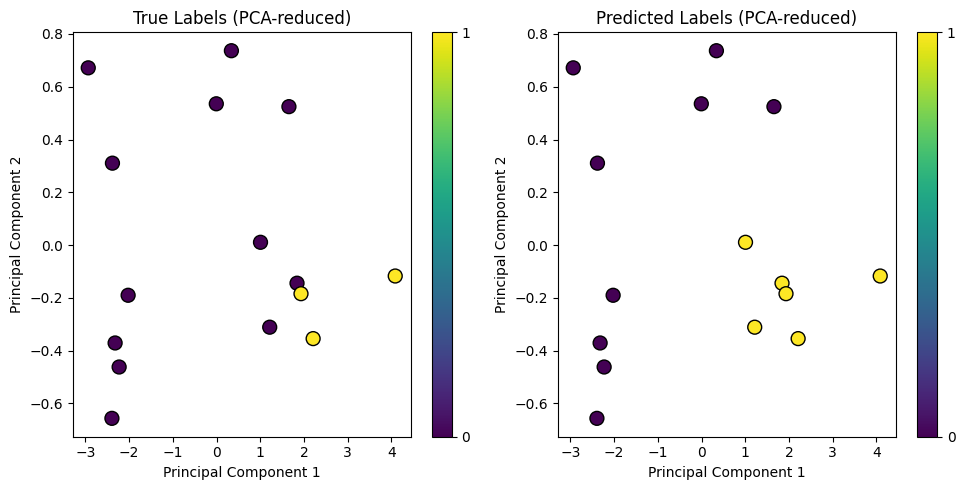

In [40]:
from sklearn.decomposition import PCA

# Perform PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test)  # Reduce test data to 2D

# Plot PCA-reduced data
plt.figure(figsize=(10, 5))

# Plot for true labels
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_test, cmap='viridis', edgecolor='k', s=100)
plt.title("True Labels (PCA-reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(ticks=[0, 1, 2])

# Plot for predicted labels
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, cmap='viridis', edgecolor='k', s=100)
plt.title("Predicted Labels (PCA-reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(ticks=[0, 1, 2])

plt.tight_layout()
plt.show()


In [29]:
# Initialiser le classificateur k-NN avec k=3
knn = KNeighborsClassifier(n_neighbors=3)

# Entraîner le modèle
knn.fit(X_train, y_train)

# Prédire les étiquettes sur l'ensemble de test
y_pred = knn.predict(X_test)

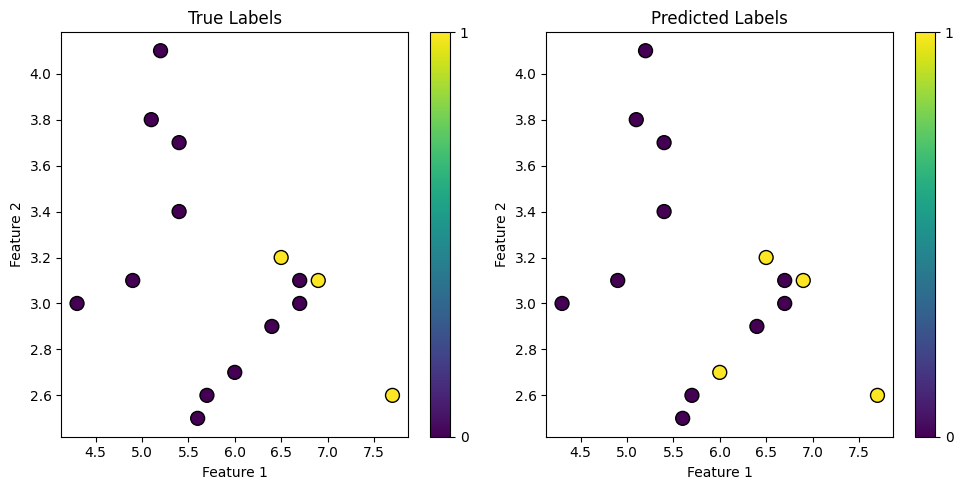

In [32]:
import matplotlib.pyplot as plt
# import numpy as np

# Select two features for visualization (first two features in this case)
feature_1 = X_test[:, 0]
feature_2 = X_test[:, 1]

# Plot actual vs predicted classifications
plt.figure(figsize=(10, 5))

# Plot for true labels
plt.subplot(1, 2, 1)
plt.scatter(feature_1, feature_2, c=y_test, cmap='viridis', edgecolor='k', s=100)
plt.title("True Labels")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(ticks=[0, 1, 2])

# Plot for predicted labels
plt.subplot(1, 2, 2)
plt.scatter(feature_1, feature_2, c=y_pred, cmap='viridis', edgecolor='k', s=100)
plt.title("Predicted Labels")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(ticks=[0, 1, 2])

plt.tight_layout()
plt.show()


In [30]:
from sklearn import svm
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

<ipython-input-42-1e6c96258a72>:29: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


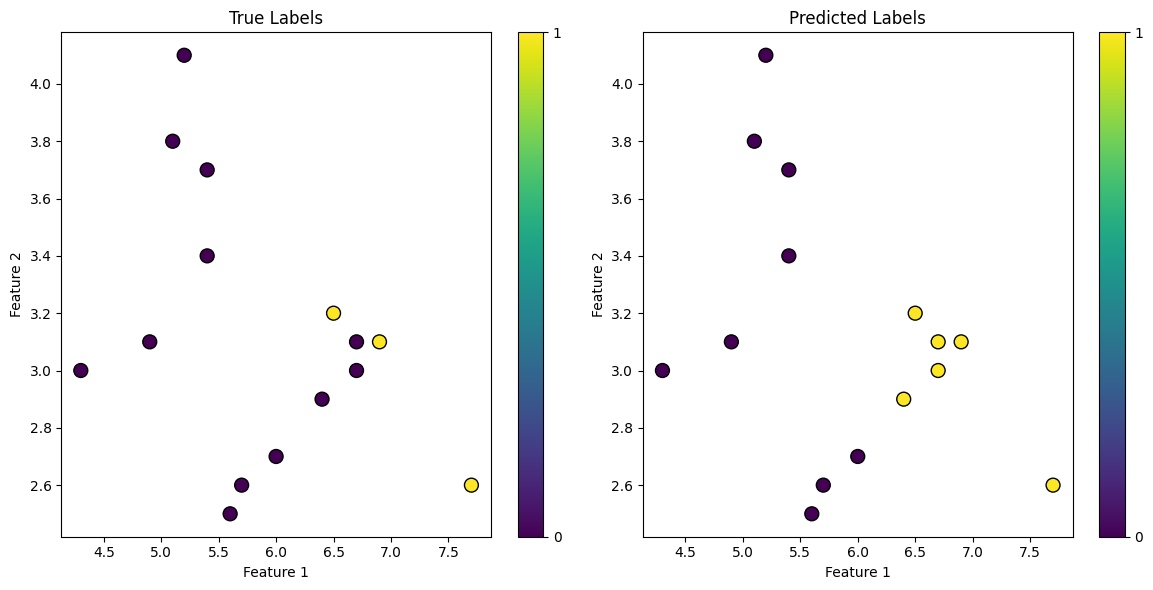

In [42]:
# import matplotlib.pyplot as plt
# import numpy as np
from sklearn import svm
# from sklearn.model_selection import train_test_split

# Let's assume we are using the same X_train, X_test, y_train, y_test from above

# Train SVM model with a linear kernel
clf = svm.SVC(kernel='poly')
clf.fit(X_train[:, :2], y_train)  # Only using the first two features for visualization
y_pred = clf.predict(X_test[:, :2])

# Create a meshgrid for plotting decision boundaries
h = .02  # Step size in the mesh
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict the decision boundary for each point in the meshgrid
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(12, 6))

# Plot decision boundary and margins
plt.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')

# Plot test data (True labels)
plt.subplot(1, 2, 1)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis', edgecolor='k', s=100)
plt.title('True Labels')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(ticks=[0, 1, 2])

# Plot test data (Predicted labels)
plt.subplot(1, 2, 2)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='viridis', edgecolor='k', s=100)
plt.title('Predicted Labels')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(ticks=[0, 1, 2])

plt.tight_layout()
plt.show()


In [ ]:
!pip install -U scikit-learn

In [44]:
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# X = df.iloc[:,0:4].to_numpy()
# y=df.iloc[:,4].to_numpy()
# df['test']=y
# df['test'] = df['test'].replace('Iris-setosa', 0)
# df['test'] = df['test'].replace('Iris-virginica', 1)
# df['test'] = df['test'].replace('Iris-versicolor', 0)
# #df['test'] = df['test'].replace(' pp', 0)
# y=df['test'].to_numpy()

# X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.1, random_state=42)


# Calcul de la sensibilité (recall)
def sensitivity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp / (tp + fn)

# Calcul de la spécificité
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

# Initialiser le classificateur k-NN avec k=3
knn = KNeighborsClassifier(n_neighbors=3)

# Entraîner le modèle
knn.fit(X_train, y_train)

# Prédire les étiquettes sur l'ensemble de test
y_pred = knn.predict(X_test)

recall = recall_score(y_test, y_pred)
specificity_val = specificity(y_test, y_pred)
g_mean = (recall * specificity_val) ** 0.5
print("recall",recall)
print("specificity_val",specificity_val)
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("G-M",g_mean)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1-score:",metrics.f1_score(y_test, y_pred))
print("AUC:",metrics.roc_auc_score(y_test, y_pred))


recall 1.0
specificity_val 0.9166666666666666
Precision: 0.75
Recall: 1.0
G-M 0.9574271077563381
Accuracy: 0.9333333333333333
F1-score: 0.8571428571428571
AUC: 0.9583333333333333


In [49]:

clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

recall = recall_score(y_test, y_pred)
specificity_val = specificity(y_test, y_pred)
g_mean = (recall * specificity_val) ** 0.5
print("recall",recall)
print("specificity_val",specificity_val)
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("G-M",g_mean)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1-score:",metrics.f1_score(y_test, y_pred))
print("AUC:",metrics.roc_auc_score(y_test, y_pred))

recall 1.0
specificity_val 0.9166666666666666
Precision: 0.75
Recall: 1.0
G-M 0.9574271077563381
Accuracy: 0.9333333333333333
F1-score: 0.8571428571428571
AUC: 0.9583333333333333
